### Notebook Information

The purpose of this notebook is to generate figures and figure components for the journal publication.

In [1]:
SAVE_FOLDER="./"
FIG_DPI = 1200

#%load_ext autoreload
#%autoreload 2

# Third-Party Imports
import numpy as np
import matplotlib.pyplot as plt
from numpy import cos, sin
from numpy.random import randn

from matplotlib.cm import ScalarMappable
from matplotlib import colors
import matplotlib as mpl
from matplotlib.patches import Polygon, Ellipse
from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec

from scipy.ndimage import gaussian_filter

np.random.seed(0)

# Change some plot behaviors
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.left'] = False
mpl.rcParams['axes.spines.bottom'] = False
mpl.rcParams["legend.markerscale"] = 1.5
mpl.rcParams["legend.labelspacing"] = 1.2

In [2]:
def draw_and_color_beam(axes: mpl.axes.Axes, x:np.ndarray, u:np.ndarray, beam_width:float, lcolor:str='black'):
    # Draw frame of the rod
    axes.plot(x, u, linestyle='--', color='black') # dashed mid-line
    axes.plot(x, u+beam_width/2, linestyle='-', lw=2, color=lcolor) # top solid line
    axes.plot(x, u-beam_width/2, linestyle='-', lw=2, color=lcolor) # bottom solid line
    # Fill the space between the lines
    axes.fill_between(x, u+beam_width/2, u-beam_width/2, color=lcolor, alpha=0.8)
    # Add end-cap left lines
    line=Line2D([x_min, x_min], [u[0]-beam_width/2, u[0]+beam_width/2], 
                linestyle='-', lw=2, color=lcolor)
    axes.add_line(line)
    # and the right line
    line=Line2D([x_max, x_max], [u[-1]-beam_width/2, u[-1]+beam_width/2], 
                linestyle='-', lw=2, color=lcolor)
    axes.add_line(line)

def draw_rod_support(axes: mpl.axes.Axes, tip: tuple, width: float, height: float):
    '''
    This method draws a beam support (see second panel from top in figure below)
    Input: 
        axes - Matplotlib.axes.Axes object on which to draw
        tip - tuple describing the right-most point of the beam support
        width - width of the beam support
    Output:
        None (this object draws the beam support object, returns nothing)
    '''
    # Compute the point positions on the left side of the beam support
    tx, ty = tip
    lx = tx - width
    lyt = ty + height/2
    lyl = ty - height/2
    # Define the top left point and bottom left point
    top_pt = [lx, lyt]
    bot_pt = [lx, lyl]
    # Make a list of points for the polygon
    points = [tip, top_pt, bot_pt]
    # Draw the polygon
    polygon = Polygon(points, closed=True, fc='gray', edgecolor='black', alpha=0.8)
    axes.add_patch(polygon)
    
    # Compute the center point of the support, then draw a circle there
    cx = tx - 0.65*width
    centroid = [cx, ty]
    ellipse = Ellipse(centroid, width/3, height/4,fc='black')
    axes.add_patch(ellipse)
    
def turn_off_ticks(axes: mpl.axes.Axes):
    axes.tick_params(axis='y', which='both', left=False, labelleft=False)
    axes.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
    
def draw_end_support(axes: mpl.axes.Axes, tip: tuple, width: float, height: float):
    '''
    This method draws a beam support (see second panel from top in figure below)
    Input: 
        axes - Matplotlib.axes.Axes object on which to draw
        tip - tuple describing the right-most point of the beam support
        width - width of the beam support
    Output:
        None (this object draws the beam support object, returns nothing)
    '''
    # Compute the point positions on the left side of the beam support
    tx, ty = tip
    # Define the top left point and bottom left point
    vertex_2 = [tx, ty-height]
    vertex_3 = [tx-width, ty-height]
    # Make a list of points for the polygon
    points = [tip, vertex_2, vertex_3]
    # Draw the polygon
    polygon = Polygon(points, closed=True, fc='gray', edgecolor='black', alpha=0.8)
    axes.add_patch(polygon)

    
def draw_clamps(axes: mpl.axes.Axes, tip: tuple, width: float, height: float, beamwidth: float, wfrac = 0.3):
    '''
    This method draws a beam support (see second panel from top in figure below)
    Input: 
        axes - Matplotlib.axes.Axes object on which to draw
        tip - tuple describing the right-most point of the beam support
        width - width of the beam support
    Output:
        None (this object draws the beam support object, returns nothing)
    '''
    # Compute the point positions on the left side of the beam support
    tx, ty = tip
    # Define the points in the drawing
    points = [tip]
    points.append([tx, ty+beamwidth/2])
    points.append([tx+wfrac*width, ty+beamwidth/2])
    points.append([tx+wfrac*width, ty+beamwidth/2 + height/4])
    points.append([tx-wfrac*width, ty+beamwidth/2+height/2])
    points.append([tx-(1-wfrac)*width, ty+beamwidth/2+height/2])
    points.append([tx-(1-wfrac)*width, ty-beamwidth/2-height/2])
    points.append([tx-wfrac*width, ty-beamwidth/2-height/2])
    points.append([tx+wfrac*width, ty-beamwidth/2 - height/4])
    points.append([tx+wfrac*width, ty-beamwidth/2])
    points.append([tx, ty-beamwidth/2])
    # Draw the polygon
    polygon = Polygon(points, closed=True, fc='gray', edgecolor='black', alpha=0.8)
    axes.add_patch(polygon)

In [3]:
#%%time

###################################
## Generate some data for figure ##
###################################

# Define the independent variable
x_min = 0; x_max = 5; dx = 0.01;
x = np.linspace(x_min, x_max, int((x_max-x_min)/dx)+1)

# And compute some made up u, p, f
f = 5*sin(2*x) + 1.2*cos(x) + 0.9*sin(1.2*x)
u = 2*sin((2*np.pi/(x_min-x_max))*x)
p_func = lambda x: 0.5*sin(x) + 0.1*sin(12*x) + 0.25*cos(4*x) - cos(x)
q_func = lambda x: 0.4*np.sin(3*x) + 0.15*np.cos(8*x) -2

# Compute the true p vector
p = np.vectorize(p_func)(x)
q = np.vectorize(q_func)(x)

# And make up a predicted p, noising up the outer regions
p_uplim = 4.85
p_lowlim = 0.15
predicted_p = []
predicted_q = []
for x_val in x:
    p_val = p_func(x_val)
    q_val = q_func(x_val)
    if x_val > p_uplim or x_val < p_lowlim:
        p_val += 0.4*randn()*sin(np.pi/(abs(1.1-x_val)))
        q_val += 0.4*randn()*sin(np.pi/(abs(1.1-x_val)))
    predicted_p.append(p_val)
    predicted_q.append(q_val)
predicted_p = gaussian_filter(input=np.asarray(predicted_p), sigma=1.0, mode='nearest')

CPU times: user 9.25 ms, sys: 2.37 ms, total: 11.6 ms
Wall time: 9.63 ms


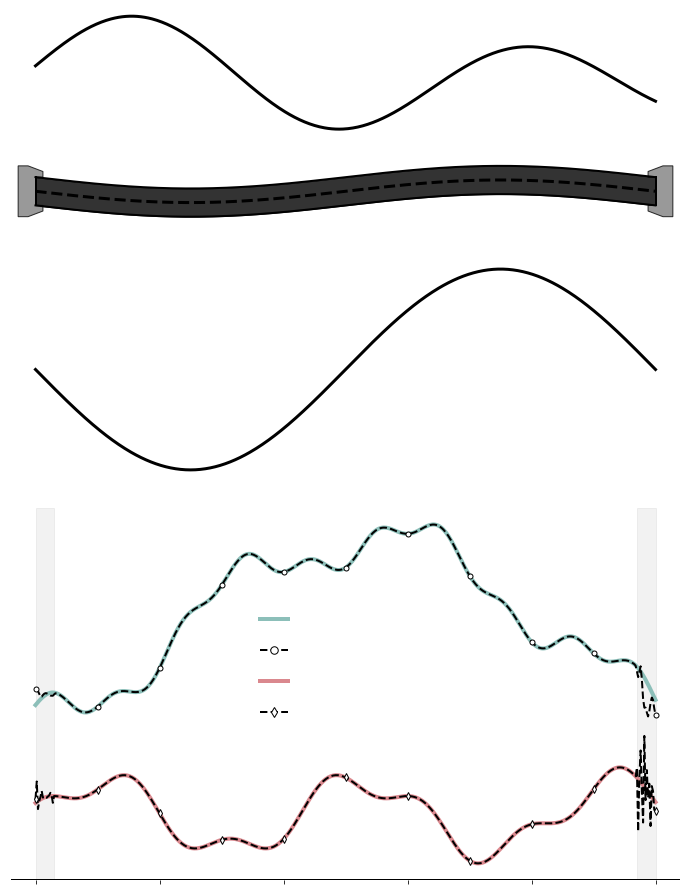

12.0 16.0


In [15]:
#####################################
## PLOT WITH P and Q ##
#####################################

# Create a figure
fig = plt.figure(figsize = (12,16))

# Define the relative heights of the subplots
heights = [1, 1, 2, 3]
spec = fig.add_gridspec(ncols=1, nrows=4, width_ratios=[1], height_ratios=heights)
spec.update(wspace=0.025, hspace=0) # set the spacing between axes.
axes = [fig.add_subplot(spec[i,0]) for i in range(4)]

# Plot forcing function
f_plot = axes[0].plot(x, f, color='black')

# Create the beam drawing
beam_width = 5
supp_width = 0.2
supp_height = 4
# Draw the rod support (function above)
#draw_rod_support(axes=axes[1], tip=[0.25,0], width=supp_width, height = supp_height)
# Draw the beam deflection
draw_and_color_beam(axes=axes[1], x=x, u=u, beam_width=beam_width)
# And draw end supports
#draw_end_support(axes=axes[1], tip=[x[0],u[0]-beam_width/2], width=supp_width, height=supp_height)
#draw_end_support(axes=axes[1], tip=[x[-1],u[-1]-beam_width/2], width=-1*supp_width, height=supp_height)
draw_clamps(axes=axes[1], tip=[x[0],u[0]], width=supp_width, height=supp_height, beamwidth = beam_width)
draw_clamps(axes=axes[1], tip=[x[-1],u[-1]], width=-1*supp_width, height=supp_height, beamwidth = beam_width)
# Adjust the y-axis limits for the beam drawing
axes[1].set_ylim([-12,10])

# Plot state variable response
u_plot = axes[2].plot(x, u, color='black')
# And adjust the y-lims for spacing reasons
uymin, uymax = axes[2].get_ylim()
axes[2].set_ylim([1.25*uymin, uymax])

# Plot material properties (true, then predicted)
true_line_props = dict(linestyle='-', lw=4)
pred_line_props = dict(color='black', ms=5, mec='black', mfc='white', lw=2, linestyle='--', markevery=50)
reg_props = dict(alpha=0.1, color='grey')
# Plot the lines (true/predicted)
p_color = '#8CBFB9'
q_color = '#DA888E'
p_plot = axes[3].plot(x, p, label='True p(x)', color=p_color, **true_line_props)
pp_plot = axes[3].plot(x, predicted_p, label='Predicted p(x)', marker='o', **pred_line_props)
q_plot = axes[3].plot(x, q, label='True q(x)', color=q_color, **true_line_props)
pq_plot = axes[3].plot(x, predicted_q, label='Predicted q(x)', marker='d', **pred_line_props)
# Shade the region where the material properties start to become incorrectly computed
axes[3].axvspan(min(x), p_lowlim, **reg_props)
axes[3].axvspan(p_uplim, max(x), **reg_props)
# And draw vertical boundary lines to those regions
#axes[3].axvline(p_lowlim, linestyle='--', color='red')
#axes[3].axvline(p_uplim, linestyle='--', color='red')
# Draw a new axis bottom line, so that the bottom line only goes from x=0 to x=5
xlims = [x_min-supp_width, x_max+supp_width]
axes[3].axhline(axes[3].get_ylim()[0], 0, 1, linestyle='-', color='black')
# Turn off x-tick labels
axes[3].tick_params(axis='x', which='both', labelbottom=False)
# Slap a legend on this bad-ass plot
axes[3].legend(labels=('','','',''), edgecolor='None', fontsize=14, bbox_to_anchor = (0.45, 0.75), )#loc='lower center')

### All the labeling happens here:
## f(x) and u(x) plot labels
#axes[0].set_ylabel("f(x)")
#axes[2].set_ylabel("u(x)")
## p(x) labels
#axes[3].set_ylabel("p(x)")
#axes[3].set_xlabel("Spatial Coordinate, 'x'")
    
# And do some formatting for each of the axes/subplots:
for i in [0,1,2,3]:
    # Adjust the x-axis and y-axis labels and tickmarkings
    axes[i].tick_params(axis='y', which='both', left=False, labelleft=False)
    if i != 3: axes[i].tick_params(axis='x', which='both', bottom=False, labelbottom=False)
    # Set the x-lim for all the figures, so that they match
    axes[i].set_xlim(xlims)

fname = SAVE_FOLDER + 'fig1a_p-q.svg'
plt.savefig(fname, dpi=FIG_DPI, transparent=True)
# Show plot
plt.show()

print(fig.get_figwidth(), fig.get_figheight())

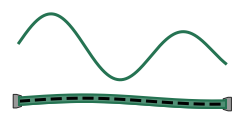

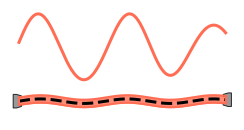

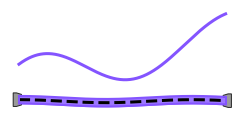

In [5]:
#####################################
## Create the figure and plot data ##
#####################################

# Create the beam drawing
beam_width = 5
supp_width = 0.2
supp_height = 4
xlims = [x_min-supp_width, x_max+supp_width]

# Define colors for each plot
colors = ['blue', 'green', 'magenta', 'orange']

# purple, orange, turqoise
colors = ['#54ffb8', '#ff6e54', '#8454ff', '#ffc354']

# blue to green
colors = ['#225ea8', '#41b6c4', '#a1dab4']

# purple, orange, hunter green
colors = ['#ba66ff', '#5c8f24', '#ff6b30']

colors = ['#257352', '#ff6e54', '#8454ff', '#ffc354']

# And set the number of examples to be plotted
num_example = 3

# Prepare different f and u functions:
fs = [
        5*sin(2*x) + 1.2*cos(x) + 0.9*sin(1.2*x),
        7*sin(3*x) + 1.2*cos(2*x) + 0.5*sin(5*x),
        4*sin(0.2*x) + 1.5*cos(1.3*x) + 0.9*sin(1.2*x),
        5*cos(0.7*x) + 0.6*cos(x) + 3*cos(1.2*x)
     ]

us = [2*sin(x), 1.5*sin(3*x), cos(1.5*x), sin(2*x)+0.5*cos(0.5*x)]



for i in range(num_example):
    # Create a figure
    fig = plt.figure(figsize = (4,2))

    # Define the relative heights of the subplots
    heights = [2, 1]
    spec = fig.add_gridspec(ncols=1, nrows=2, width_ratios=[1], height_ratios=heights)
    spec.update(wspace=0.025, hspace=0) # set the spacing between axes.
    axes = [fig.add_subplot(spec[j,0]) for j in range(2)]

    # Plot forcing function
    f_plot = axes[0].plot(x, fs[i], color=colors[i])
    turn_off_ticks(axes[0])
    axes[0].set_xlim(xlims)
    # Draw the beam deflection
    draw_and_color_beam(axes=axes[1], x=x, u=us[i], beam_width=beam_width, lcolor=colors[i])
    # Draw the rod support (function above)
    #draw_rod_support(axes=axes[1], tip=[0.25,0], width=supp_width, height = supp_height)
    draw_clamps(axes=axes[1], tip=[x[0],us[i][0]], width=1*supp_width, height=supp_height, beamwidth = beam_width)
    draw_clamps(axes=axes[1], tip=[x[-1],us[i][-1]], width=-1*supp_width, height=supp_height, beamwidth = beam_width)

    # Adjust the y-axis limits for the beam drawing
    axes[1].set_ylim([-12,12])
    turn_off_ticks(axes[1])
    axes[1].set_xlim(xlims)

    fname = SAVE_FOLDER + 'fig1b_{}_panel.svg'.format(i)
    plt.savefig(fname, dpi=FIG_DPI, transparent=True)

    # Show plot
    plt.show()

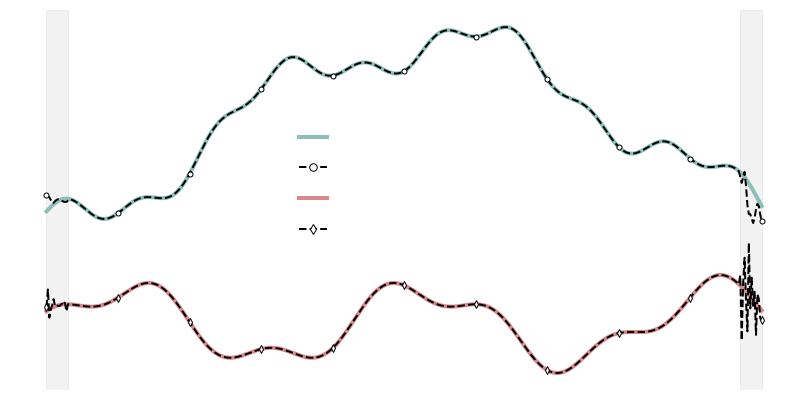

In [6]:
fs = (14.1,7)
fig = plt.figure(figsize=fs)
fig.add_subplot()
ax = plt.gca()


# Plot the lines (true/predicted)
p_plot = ax.plot(x, p, label='True p(x)', color=p_color, **true_line_props)
pp_plot = ax.plot(x, predicted_p, label='Predicted p(x)', marker='o', **pred_line_props)
q_plot = ax.plot(x, q, label='True q(x)', color=q_color, **true_line_props)
pq_plot = ax.plot(x, predicted_q, label='Predicted q(x)', marker='d', **pred_line_props)

# Shade the region where the material properties start to become incorrectly computed
ax.axvspan(min(x), p_lowlim, **reg_props)
ax.axvspan(p_uplim, max(x), **reg_props)
# Draw a new axis bottom line, so that the bottom line only goes from x=0 to x=5
xlims = [x_min-supp_width, x_max+supp_width]
#ax.axhline(ax.get_ylim()[0], 0, 1, linestyle='-', color='black')
# Turn off x-tick labels
ax.tick_params(axis='x', which='both', labelbottom=False)

# Slap a legend on this bad-ass plot
ax.legend(labels=('','','',''), edgecolor='None', fontsize=14, bbox_to_anchor = (0.35, 0.37), )#loc='lower center')
# Turn off x-tick labels
turn_off_ticks(ax)

fname = SAVE_FOLDER + 'props_plot.svg'
plt.savefig(fname, dpi=FIG_DPI, transparent=True)
plt.show()

### All the labeling happens here:

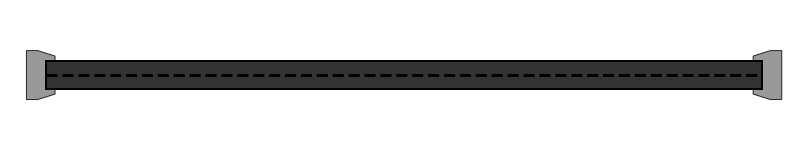

In [7]:
fs = (14.1,2.4)
fig = plt.figure(figsize = fs)
fig.add_subplot()
ax = plt.gca()


# Create the beam drawing
beam_width = 5
supp_width = 0.2
supp_height = 4
# Draw the beam deflection
draw_and_color_beam(axes=ax, x=x, u=np.zeros(x.shape), beam_width=beam_width)
# Draw the rod support (function above)
draw_clamps(axes=ax, tip=[x[0],0], width=supp_width, height=supp_height, beamwidth = beam_width)
draw_clamps(axes=ax, tip=[x[-1],0], width=-1*supp_width, height=supp_height, beamwidth = beam_width)
# Adjust the y-axis limits for the beam drawing
ax.set_ylim([-12,12])
turn_off_ticks(ax)

fname = SAVE_FOLDER + 'flat_beam.svg'
plt.savefig(fname, dpi=FIG_DPI, transparent=True)

plt.show()
